In [14]:
%reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from tqdm.notebook import tqdm
import librosa
import librosa.display
from random import shuffle
from skimage.transform import resize
import warnings


In [15]:
warnings.filterwarnings('ignore')

### LISTAGE DES FICHIERS CONTENUS DANS *DATA*

In [16]:
HOUSE_FOLDER = "/home/george/code/clumzy/electronic_tagger/DATA/HOUSE"
TECHNO_FOLDER = "/home/george/code/clumzy/electronic_tagger/DATA/TECHNO"

exts = ['*.mp3', '*.aiff', '*.flac','*.wav']

house_files = [f for ext in exts for f in glob(os.path.join(HOUSE_FOLDER, ext))]
techno_files = [f for ext in exts for f in glob(os.path.join(TECHNO_FOLDER, ext))]
shuffle(house_files)
shuffle(techno_files)

### FEATURE MAKER FUNCTION & SCALER FUNCTION

Ces fonctions nous servent à scaler et créer **l'image feature** pour un fichier donné.

In [17]:
def rgb_transform(data):
    return (((data+abs(data.min()))/(data+abs(data.min())).max())*255).astype(np.uint8)

def song_to_img(file, hop_length=2048,num_sample=6, sample_length=5, sample_rate=44100):
    warnings.filterwarnings('ignore')
    HOP_LENGTH = hop_length
    NUM_SAMPLE = num_sample
    SAMPLE_LENGTH = sample_length
    SAMPLING_RATE = sample_rate

    song = librosa.load(file, sr=SAMPLING_RATE)[0]

    samples = SAMPLING_RATE*SAMPLE_LENGTH
    song_inter = np.linspace(0,(song.shape[0]-SAMPLING_RATE*6),NUM_SAMPLE).astype(int)
    song_extracts = np.hstack([song[song_inter[i]:song_inter[i]+samples] for i in range(0,NUM_SAMPLE)])
    
    #CALCUL DE LA FFT POUR LES PERCUSSIONS
    stft = librosa.stft(song_extracts, hop_length=HOP_LENGTH)
    harmonic, percussive = librosa.decompose.hpss(stft)
    p = librosa.amplitude_to_db(percussive, ref=np.max) #type: ignore

    #CALCUL DU MFCC, LES FREQUENCES QUE L'ON ENTEND
    mfcc_song = librosa.feature.mfcc(y=song_extracts, n_mfcc=13, sr=SAMPLING_RATE, lifter=512, hop_length=HOP_LENGTH)

    #CALCUL DU CHROMAGRAMME (LES NOTES)
    chroma = librosa.feature.chroma_stft(y=song_extracts, sr=SAMPLING_RATE, hop_length=HOP_LENGTH, center = False)
    r = rgb_transform(resize(p, (646,646), anti_aliasing=None, mode="reflect", order=0))

    g_tempo_bottom = resize(mfcc_song, (646,646), anti_aliasing=None, mode="reflect", order=0)[:int(r.shape[0]/13)+1]
    g_tempo_top = resize(mfcc_song, (646,646), anti_aliasing=None, mode="reflect", order=0)[int(r.shape[0]/13)+1:]
    g = np.vstack([rgb_transform(g_tempo_bottom), rgb_transform(g_tempo_top)])

    b = rgb_transform(resize(chroma, (646,646), anti_aliasing=None, mode="reflect", order=0))
    rgb = np.dstack((r,g,b)).astype(np.uint8)
    return rgb

### EXEMPLE D'UNE CREATION DE FEATURES

In [18]:
SONG_NUM = 25
HOP_LENGTH = 2048
NUM_SAMPLE = 6
SAMPLE_LENGTH = 5
SAMPLING_RATE = 44100


house_waveforms = [librosa.load(house_file, sr=SAMPLING_RATE)[0] for house_file in tqdm(house_files[SONG_NUM:SONG_NUM+1])]
#techno_waveforms = [librosa.load(techno_file, sr=None) for techno_file in tqdm(techno_files[SONG_NUM:SONG_NUM+1])]

song = house_waveforms[0]

samples = SAMPLING_RATE*SAMPLE_LENGTH
# LA CHANSON EST DECOUPEE EN NUM_SAMPLES MORCEAUX, DE LONGEUR SAMPLE_LENGTH(SECONDES)
song_inter = np.linspace(0,(song.shape[0]-SAMPLING_RATE*6),NUM_SAMPLE).astype(int)
song_extracts = np.hstack([song[song_inter[i]:song_inter[i]+samples] for i in range(0,NUM_SAMPLE)])

house_files[SONG_NUM]

  0%|          | 0/1 [00:00<?, ?it/s]

"/home/george/code/clumzy/electronic_tagger/DATA/HOUSE/Alex O'Rion - Echium (Original Mix).mp3"

In [19]:

stft = librosa.stft(song_extracts, hop_length=HOP_LENGTH)


In [20]:
harmonic, percussive = librosa.decompose.hpss(stft)
p = librosa.amplitude_to_db(percussive, ref=np.max)

In [21]:
#CALCUL DE LA FFT POUR LES PERCUSSIONS
stft = librosa.stft(song_extracts, hop_length=HOP_LENGTH)
harmonic, percussive = librosa.decompose.hpss(stft)
p = librosa.amplitude_to_db(percussive, ref=np.max)

#CALCUL DU MFCC, LES FREQUENCES QUE L'ON ENTEND
mfcc_song = librosa.feature.mfcc(y=song_extracts, n_mfcc=13, sr=SAMPLING_RATE, lifter=512, hop_length=HOP_LENGTH)

#CALCUL DU CHROMAGRAMME (LES NOTES)
chroma = librosa.feature.chroma_stft(y=song_extracts, sr=SAMPLING_RATE, hop_length=HOP_LENGTH, center = False)

In [22]:
r = rgb_transform(resize(p, (646,646), anti_aliasing=None, mode="reflect", order=0)).astype(np.uint)

g_tempo_bottom = resize(mfcc_song, (646,646), anti_aliasing=None, mode="reflect", order=0)[:int(r.shape[0]/13)+1]
g_tempo_top = resize(mfcc_song, (646,646), anti_aliasing=None, mode="reflect", order=0)[int(r.shape[0]/13)+1:]

g = np.vstack([rgb_transform(g_tempo_bottom), rgb_transform(g_tempo_top)]).astype(np.uint)
b = rgb_transform(resize(chroma, (646,646), anti_aliasing=None, mode="reflect", order=0)).astype(np.uint)

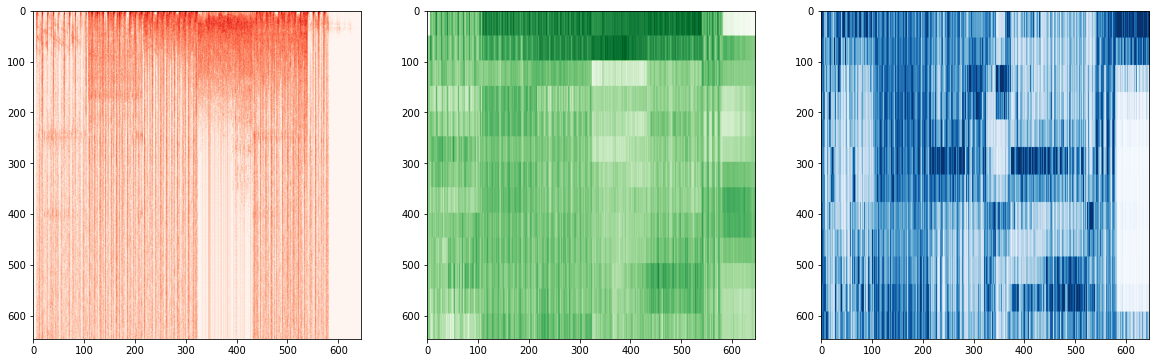

In [23]:
plt.figure(figsize=(20,60))
plt.subplot(1,3,1)
plt.imshow((r), cmap="Reds")
plt.subplot(1,3,2)
plt.imshow(g, cmap="Greens")
plt.subplot(1,3,3)
plt.imshow(b, cmap="Blues")
plt.show()

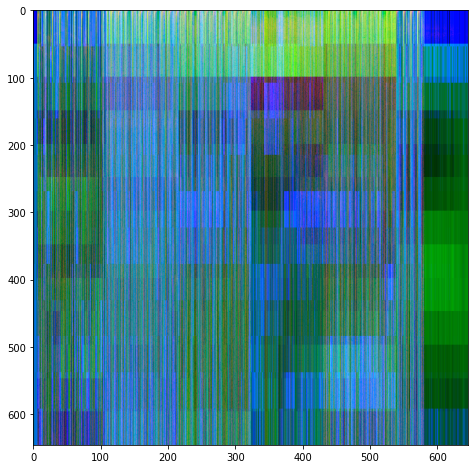

In [24]:
rgb = np.dstack((r,g,b))
plt.figure(figsize=(8,8))
plt.imshow(rgb)

### CREATION DES FEATURES POUR LA LISTE DES MUSIQUES

In [25]:
from joblib import Parallel, delayed

START_SONG = 0
HOW_MANY = 200
ar1 = np.array(Parallel(n_jobs=4)(delayed(song_to_img)(house_file) for house_file in tqdm(house_files[START_SONG:START_SONG+HOW_MANY])), dtype=np.uint8)
ar2 = np.array(Parallel(n_jobs=4)(delayed(song_to_img)(techno_file) for techno_file in tqdm(techno_files[START_SONG:START_SONG+HOW_MANY])), dtype=np.uint8)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [46]:
X_1 = np.vstack([ar1, ar2])

X_2 = [os.path.basename(house_file) for house_file in tqdm(house_files[START_SONG:START_SONG+HOW_MANY])] + [os.path.basename(techno_file) for techno_file in tqdm(techno_files[START_SONG:START_SONG+HOW_MANY])]

X = (X_1,X_2)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

### EXPORT DES FEATURES

In [47]:
import pickle
pickle.dump( X, open( os.path.join("/home/george/code/clumzy/electronic_tagger/images","images.pkl"), "wb" ) )

### CREATION DE LA TARGET: 1 = HOUSE et 0 = TECHNO

In [32]:
y = np.hstack([np.ones(len(X[0])//2),np.zeros(len(X[0])//2)]).astype(int)

In [41]:
len(X[1])

400

### AFFICHAGE DES FEATURES

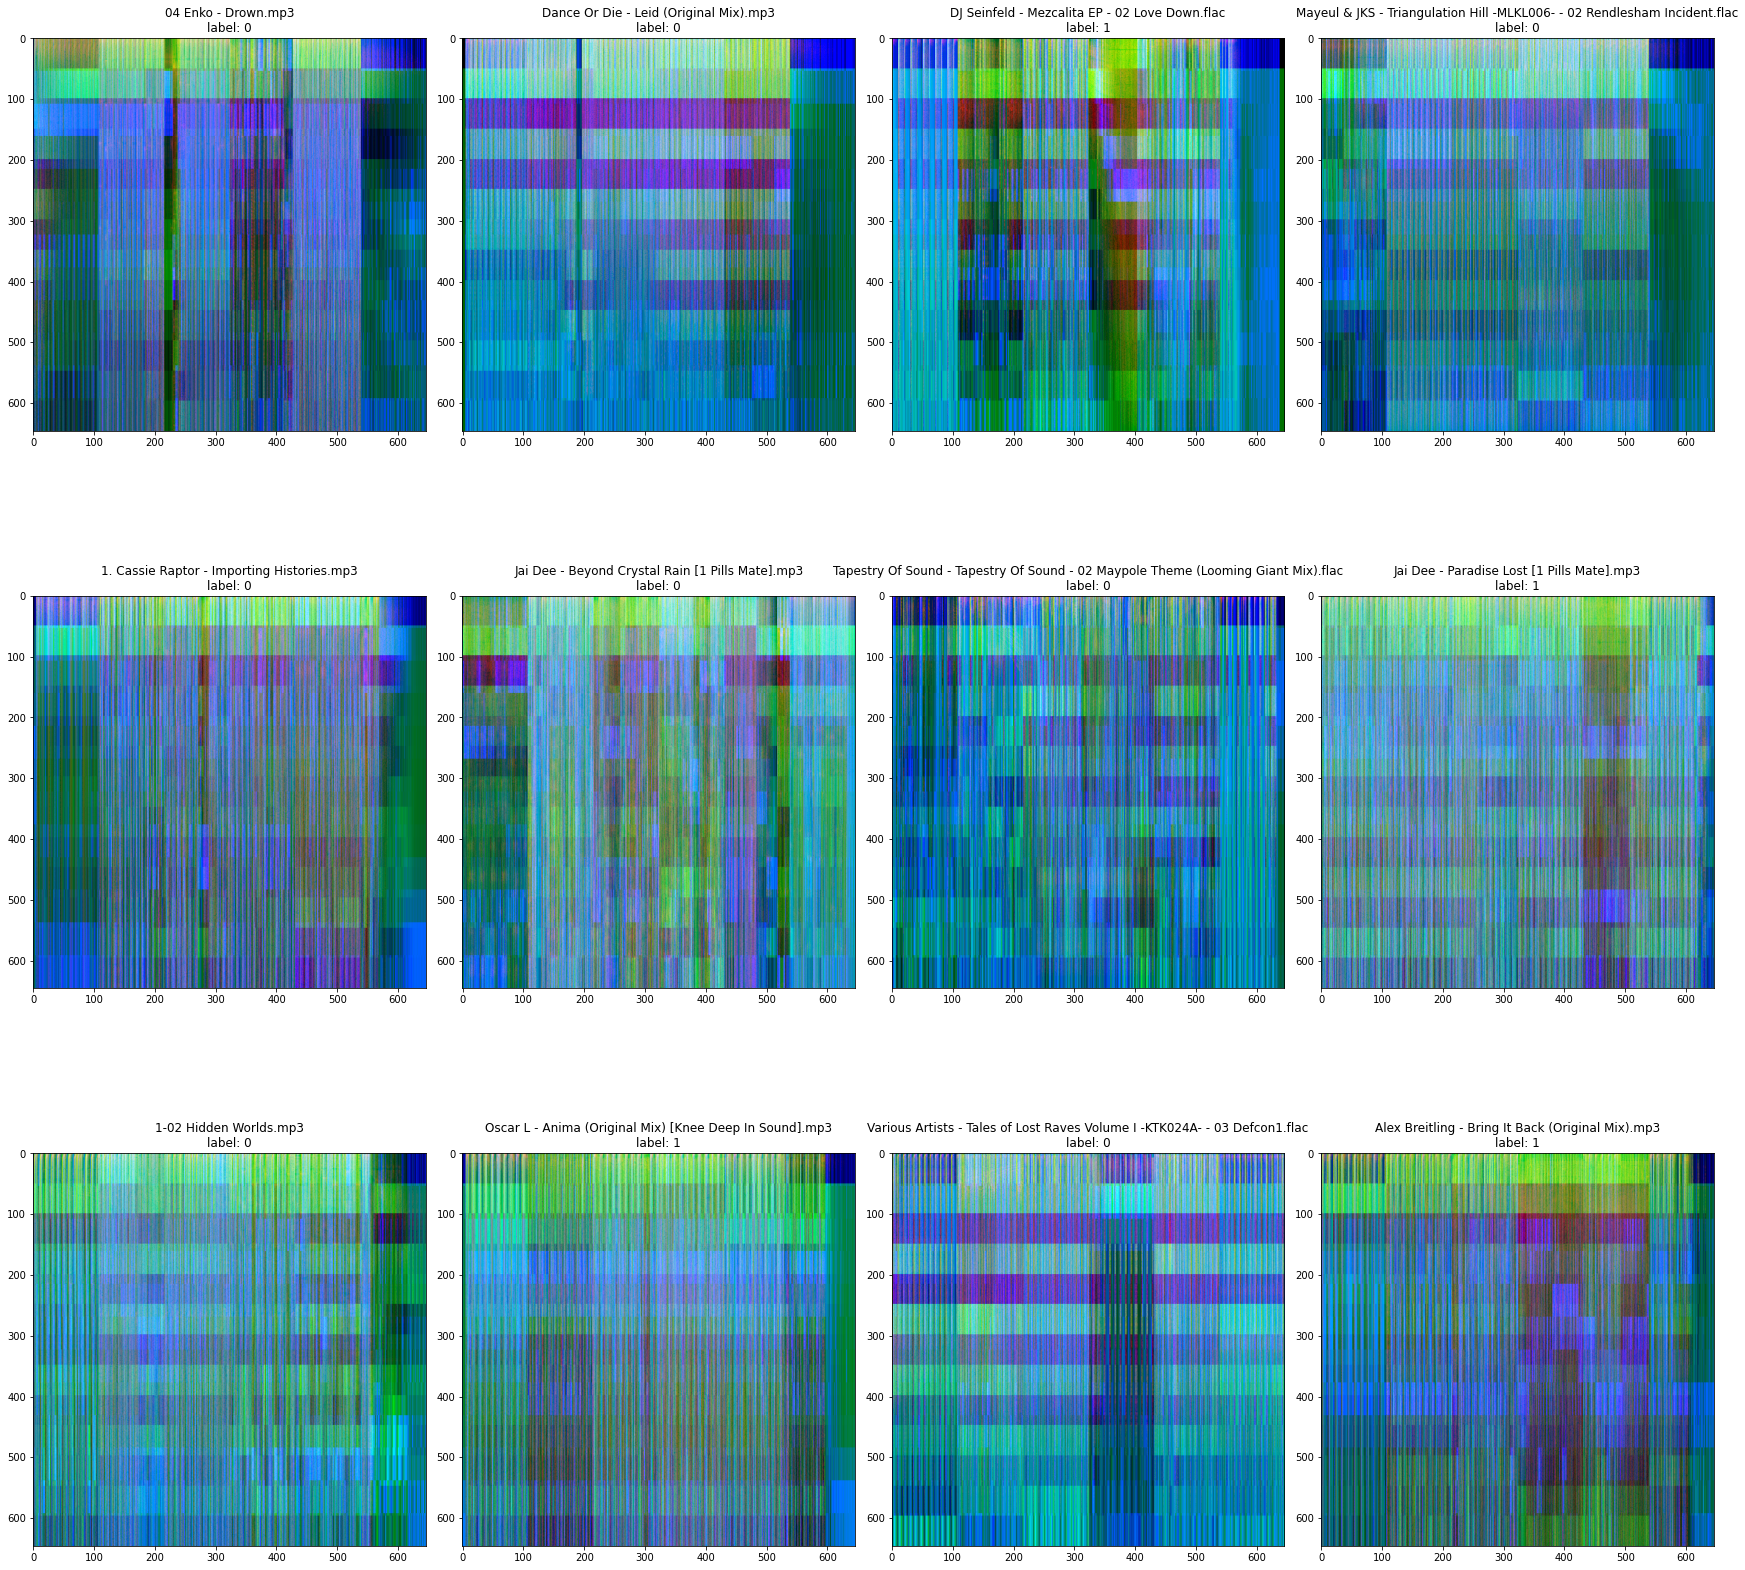

In [45]:
images = np.random.choice(range(X[0].shape[0]), 12, replace = False) #type: ignore
plt.figure(2, figsize=(24, 24))
for i in range(1, 13):
    plt.subplot(3, 4, i)
    plt.imshow(X[0][images[i-1]])
    plt.title(f"{X[1][images[i-1]]}\nlabel: {y[images[i-1]]}")
plt.tight_layout()
plt.show()